# Assertion RLA

**From 20 October 2022, major re-write and restructuring of the code and classes.**

**From 18 May 2022, consistent sampling seems to be working.**

**From 1 April 2022, integrating alpha_mart, p_history, and other features.**

**From 24 October 2021, dev version implementing consistent sampling to target smaller contests.**

## Overview of the assertion audit tool

The tool requires as input:

+ audit-specific and contest-specific parameters, such as
    - whether to sample with or without replacement
    - the name of the risk function to use, and any parameters it requires
    - a risk limit for each contest to be audited
    - the social choice function for each contest, including the number of winners
    - candidate identifiers for each contest
    - reported winner(s) for each contest
    - an upper bound on the number of ballot cards that contain each contest
    - an upper bound on the total number of cards across all contests
    - whether to use card style information to target sampling
+ a ballot manifest (see below)
+ a random seed
+ a file of cast vote records (for ballot-comparison audits)
+ reported vote tallies for for each contest (for ballot-polling audits of plurality, supermajority, and approval social choice functions)
+ json files of assertions for IRV contests (one file per IRV contest)
+ human reading of voter intent from the paper cards selected for audit

`use_style` controls whether the sample is drawn from all cards (`use_style == False`) or card style information is used
to target the cards that purport to contain each contest (`use_style == True`).
In the current implementation, card style information is inferred from cast-vote records, with additional 'phantom' CVRs if there could be more cards that contain a contest than is accounted for in the CVRs.
Errors in the card style information are treated conservatively using the  "phantoms-to-evil-zombies" (~2EZ) approach ([Banuelos & Stark, 2012](https://arxiv.org/abs/1207.3413)) so that the risk limit remains valid, even if the CVRs misrepresent
which cards contain which contests.

The two ways of sampling are treated differently. 
If the sample is to be drawn only from cards that--according to the CVR--contain a particular contest, and a sampled card turns out not to
contain that contest, that is considered a discrepancy, dealt with using the ~2EZ approach.
It is assumed that every CVR corresponds to a card in the manifest, but there might
be cards cast in the contest for which there is no corresponding CVR. In that case,
phantom CVRs are created to ensure that the audit is still truly risk-limiting.

Given an independent (i.e., not relying on the voting system) upper bound on the number of cards that contain the contest, if the number of CVRs that contain the contest does not exceed that bound, we can sample from paper purported to contain the contest and use the ~2EZ approach to deal with missing CVRs. This can greatly increase the efficiency of the audit if 
some contests appear on only a small percentage of the cast cards ([Glazer, Spertus, and Stark, 2021](https://dl.acm.org/doi/10.1145/3457907)).
If there are more CVRs than the upper bound on the number of cards, extra CVRs can be deleted provided
that deletion does not change any contest outcome. See [Stark, 2022](https://arxiv.org/abs/2207.01362).
(However, if there more CVRs than cards, that is evidence of a process failure.)

Any sampled phantom card (i.e., a card for which there is no CVR) is treated as if its CVR is a non-vote (which it is), and as if its MVR was least favorable (an "evil zombie" producing the greatest doubt in every assertion, separately). Any sampled card for which there is a CVR is compared to its corresponding CVR. 
If the card turns out not to contain the contest (despite the fact that the CVR says it does), the MVR is treated in the least favorable way for each assertion (i.e., as a zombie rather than as a non-vote).

The tool helps select cards for audit, and reports when the audit has found sufficiently strong evidence to stop.

The tool exports a log of all the audit inputs except the CVR file, but including the auditors' manually determined voter intent from the audited cards.

The pre-10/2021 version used a single sample to audit all contests. 

### Internal workflow

+ Read overall audit information (including the seed) and contest information
+ Read assertions for IRV contests and construct assertions for all other contests
+ Read ballot manifest
+ Read cvrs. Every CVR should have a corresponding manifest entry.
+ Prepare ~2EZ:
    - `N_phantoms = max_cards - cards_in_manifest`
    - If `N_phantoms < 0`, complain
    - Else create `N_phantoms` phantom cards
    - For each contest `c`:
        + `N_c` is the input upper bound on the number of cards that contain `c`
        + if `N_c is None`, `N_c = max_cards - non_c_cvrs`, where `non_c_cvrs` is #CVRs that don't contain `c`
        + `C_c` is the number of CVRs that contain the contest
        + if `C_c > N_c`, complain
        + else if `N_c - C_c > N_phantoms`, complain
        + else:
            - Consider contest `c` to be on the first `N_c - C_c` phantom CVRs
            - Consider contest `c` to be on the first `N_c - C_c` phantom ballots
+ Create Assertions for every Contest. This involves also creating an Assorter for every Assertion, and a `NonnegMean` test
for every Assertion.
+ Calculate assorter margins for all assorters:
    - If `not use_style`, apply the Assorter to all cards and CVRs, including phantoms
    - Else apply the assorter only to cards/cvrs reported to contain the contest, including phantoms that contain the contest
+ Set `assertion.test.u` to the appropriate value for each assertion: `assorter.upper_bound` for polling audits or 
      `2/(2-assorter.margin/assorter.upper_bound)` for ballot-level comparison audits
+ Estimate starting sample size for the specified sampling design (w/ or w/o replacement, stratified, etc.), for chosen risk function, use of card-style information, etc.:
    - User-specified criterion, controlled by parameters. Examples:
        + expected sample size for completion, on the assumption that there are no errors
        + 90th percentile of sample size for completion, on the assumption that errors are not more frequent than specified
    - If `not use_style`, base estimate on sampling from the entire manifest, i.e., smallest assorter margin
    - Else use consistent sampling:
        + Augment each CVR (including phantoms) with a probability of selection, `p`, initially 0
        + For each contest `c`:
            - Find sample size `n_c` that meets the criterion 
            - For each non-phantom CVR that contains the contest, set `p = max(p, n_c/N_c)` 
        + Estimated sample size is the sum of `p` over all non-phantom CVRs
+ Draw the random sample:
    - Use the specified design, including using consistent sampling for style information
    - Express sample cards in terms of the manifest
    - Export
+ Read manual interpretations of the cards (MVRs)
+ Calculate attained risk for each assorter
    - Use ~2EZ to deal with phantom CVRs or cards; the treatment depends on whether `use_style == True`
+ Report
+ Estimate incremental sample size if any assorter nulls have not been rejected
+ Draw incremental sample; etc

# Audit parameters.

The overall audit involves information that is the same across contests, encapsulated in
a dict called `audit`:

* `seed`: the numeric seed for the pseudo-random number generator used to draw sample (for SHA256 PRNG)
* `sim_seed`: seed for simulations to estimate sample sizes (for Mersenne Twister PRNG)
* `quantile`: quantile of the sample size to use for setting initial sample size
* `cvr_file`: filename for CVRs (input)
* `manifest_file`: filename for ballot manifest (input)
* `use_style`: Boolean. If True, use card style information (inferred from CVRs) to target samples. If False, sample from all cards, regardless of the contest.
* `sample_file`: filename for sampled card identifiers (output)
* `mvr_file`: filename for manually ascertained votes from sampled cards (input)
* `log_file`: filename for audit log (output)
* `error_rate_1`: expected rate of 1-vote overstatements. Recommended value $\ge$ 0.001 if there are hand-marked ballots. Larger values increase the initial sample size, but make it more likely that the audit will conclude after a single round even if the audit finds errors
* `error_rate_2`: expected rate of 2-vote overstatements. 2-vote overstatements should be extremely rare.
Recommended value: 0. Larger values increase the initial sample size, but make it more likely that the audit will conclude after a single round even if the audit finds errors
* `reps`: number of replications to use to estimate sample sizes. If `reps is None`, uses a deterministic method
* `quantile`: quantile of sample size to estimate. Not used if `reps is None`
* `strata`: a dict describing the strata. Keys are stratum identifiers; values are dicts containing:
    + `max_cards`: an upper bound on the number of pieces of paper cast in the contest. This should be derived independently of the voting system. A ballot consists of one or more cards.
    + `replacement`: whether to sample from this stratum with replacement. 
    + `use_style`: True if the sample in that stratum uses card-style information.
    + `audit_type` one of Contest.POLLING, Contest.BALLOT_COMPARISON, Contest.BATCH_COMPARISON but only POLLING and BALLOT_COMPARISON are currently implemented. 
    + `test`: the name of the function to be used to measure risk. Options are `kaplan_markov`,`kaplan_wald`,`kaplan_kolmogorov`,`wald_sprt`,`kaplan_mart`, `alpha_mart`. 
Not all risk functions work with every social choice function or every sampling method. 
    + `estimator`: the estimator to be used by the risk function. Options are [FIX ME!]
    + `test_kwargs`: keyword arguments for the risk function

----

* `contests`: a dict of contest-specific data 
    + the keys are unique contest identifiers for contests under audit
    + the values are Contest objects with attributes:
        - `risk_limit`: the risk limit for the audit of this contest
        - `cards`: an upper bound on the number of cast cards that contain the contest
        - `choice_function`: `Audit.SOCIAL_CHOICE_FUNCTION.PLURALITY`, 
          `Audit.SOCIAL_CHOICE_FUNCTION.SUPERMAJORITY`, or `Audit.SOCIAL_CHOICE_FUNCTION.IRV`
        - `n_winners`: number of winners for majority contests. (Multi-winner IRV not supported)
        - `share_to_win`: for super-majority contests, the fraction of valid votes required to win, e.g., 2/3. share_to_win*n_winners must be less than 100%)
        - `candidates`: list of names or identifiers of candidates
        - `reported_winners` : list of identifier(s) of candidate(s) reported to have won. Length should equal `n_winners`.
        - `assertion_file`: filename for a set of json descriptors of Assertions (see technical documentation) that collectively imply the reported outcome of the contest is correct. Required for IRV; ignored for other social choice functions
        - `audit_type`: the audit strategy. Currently `Audit.AUDIT_TYPE.POLLING (ballot-polling)` and 
           `Audit.AUDIT_TYPE.BALLOT_COMPARISON` (ballot-level comparison audits) are implemented. 
           HYBRID and STRATIFIED are planned.
        - `test`: the risk function for the audit. Default is `NonnegMean.alpha_mart`, the alpha supermartingale test
        - `estim`: estimator for the alternative hypothesis for the test. Default is `NonnegMean.shrink_trunc`
        - `use_style`: True to use style information from CVRs to target the sample. False for polling audits or for sampling from all ballots for every contest.
        - other keys and values are added by the software, including `cvrs`, the number of CVRs that contain the contest, and `p`, the sampling fraction expected to be required to confirm the contest

In [1]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from NonnegMean import NonnegMean
from Dominion import Dominion
from Hart import Hart

In [2]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       '/Users/amanda/Downloads/oc_cvrs.zip', 
         #'cvr_file':       '/Users/Jake/Desktop/oc_cvrs.zip', 
         #'manifest_file':  'Data/OC_mock_manifest_detailed.xlsx',
         'manifest_file': 'Data/OC_full_manifest.xlsx',
         #'manifest_file': 'tests/Data/Hart_manifest.xlsx',
         'sample_file':    '',
         'mvr_file':       '',
         'log_file':       'Data/OC_example_log.json',
         'quantile':       0.8,
         'error_rate_1': 0,
         'error_rate_2': 0,
         #'error_rate_1':   0.001,
         #'error_rate_2':   0.0001,
         'reps':           100,
         'strata':         {'stratum_1': {'max_cards':   3094308, 
                                          'use_style':   True,
                                          'replacement': False,
                                          'audit_type':  Audit.AUDIT_TYPE.BALLOT_COMPARISON,
                                          'test':        NonnegMean.alpha_mart,
                                          'estimator':   NonnegMean.optimal_comparison,
                                          'test_kwargs': {}
                                         }
                           }
        })

# find upper bound on total cards across strata
audit.max_cards = np.sum([s.max_cards for s in audit.strata.values()])

In [3]:
%%time
#cvr_zip = "/Users/Jake/Desktop/oc_cvrs.zip"
cvr_zip = "/Users/amanda/Downloads/oc_cvrs.zip"

cvr_list = Hart.read_cvrs_zip(cvr_zip) # all CVRs

CPU times: user 10min 37s, sys: 11.6 s, total: 10min 48s
Wall time: 10min 51s


In [4]:
votes = CVR.tabulate_votes(cvr_list)
styles = CVR.tabulate_styles(cvr_list)
cards = CVR.tabulate_cards_contests(cvr_list) # TO DO: change this to just utilize output of tabulate_votes

In [21]:
## Code to create manifest based on CVRs given
# Create manifest_dict to store batch name and number of ballots
# manifest_dict = {}
# for i in range(len(cvr_list)):
#     cvr_id = cvr_list[i].id
#     # CVR id has format (batch number)_(sheet)
#     batch, card_num = cvr_id.split("_")
#     # check if batch already in dict
#     if batch in manifest_dict.keys():
#         # if so add one to existing ballot count
#         manifest_dict[batch] = manifest_dict[batch] + 1
#     else:
#         # otherwise create key with value one
#         manifest_dict[batch] = 1
# # Convert dict info into dataframe
# manifest = pd.DataFrame({'Batch Name' : manifest_dict.keys(),
#              'Number of Ballots' : manifest_dict.values(),
#              'Container' : 1, 
#              'Tabulator' : 99808})
# manifest['cum_cards'] = np.array(np.cumsum(manifest['Number of Ballots']))
# write csv
# manifest.to_excel('Data/OC_full_manifest.xlsx', index=False)

In [5]:
#make dict of all contests in CVRs
contests = Contest.from_cvr_list(audit, votes, cards, cvr_list)

In [6]:
# Create array of vote for 2 contests
vote_for_two = ['LAGUNA BEACH UNIFIED SCHOOL DISTRICT\nGoverning Board Member', 
               'HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member', 
               'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member', 
               'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member,\nFull Term',
               'CITY OF BREA\nMember, City Council', 
               'CITY OF CYPRESS\nMember, City Council', 
               'CITY OF FOUNTAIN VALLEY\nMember, City Council',
                'CITY OF LAGUNA BEACH\nMember, City Council',
                'CITY OF LAGUNA HILLS\nMember, City Council',
                'CITY OF MISSION VIEJO\nMember, City Council,\nTwo-Year Term',
                'RANCHO SANTA MARGARITA\nMember, City Council',
                'CITY OF SAN CLEMENTE\nMember, City Council, Full Term', 
                'CAPISTRANO BAY COMMUNITY SERVICES DISTRICT\nDirector',
                'SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector',
                'MIDWAY CITY SANITARY DISTRICT\nDirector',
                'SURFSIDE COLONY STORM WATER PROTECTION DISTRICT\nTrustee',
                'EAST ORANGE COUNTY WATER DISTRICT\nDirector',
                'SANTIAGO GEOLOGIC HAZARD ABATEMENT DISTRICT\nDirector, Full Term'
               ]
# Create array of vote for 3 contests
vote_for_three = ['SANTA ANA UNIFIED SCHOOL DISTRICT\nGoverning Board Member',
                  'CITY OF ALISO VIEJO\nMember, City Council',
                  'CITY OF HUNTINGTON BEACH\nMember, City Council',
                  'CITY OF IRVINE\nMember, City Council',
                  'CITY OF LAGUNA NIGUEL\nMember, City Council',
                  'CITY OF LAGUNA WOODS\nMember, City Council',
                  'CITY OF LA HABRA\nMember, City Council', 
                  'CITY OF LA PALMA\nMember, City Council',
                  'CITY OF TUSTIN\nMember, City Council',
                  'ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector, Full Term',
                  'SUNSET BEACH SANITARY DISTRICT\nDirector, Full Term',
                  'SANTA MARGARITA WATER DISTRICT\nDirector', 
                  'SOUTH COAST WATER DISTRICT\nDirector',
                  'BUENA PARK LIBRARY DISTRICT\nTrustee'
                 ]
# Update dictionary with correct n_winners
for con in vote_for_two:
    contests[con].n_winners = 2
    
for con in vote_for_three:
    contests[con].n_winners = 3

In [7]:
## Fix winners lists
contests['LAGUNA BEACH UNIFIED SCHOOL DISTRICT\nGoverning Board Member'].winner = ['KELLY OSBORNE', 'JAN VICKERS']
contests['HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member'].winner = ['SUSAN HENRY', 'MICHAEL SIMONS']
contests['FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['STEVE SCHULTZ', 'JEANNE GALINDO']
contests['LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member,\nFull Term'].winner = ['SUSAN M. PRITCHARD', 'OFELIA CORONA HANSON']
contests['CITY OF BREA\nMember, City Council'].winner = ['CHRISTINE MARICK', 'MARTY SIMONOFF']
contests['CITY OF CYPRESS\nMember, City Council'].winner = ['ANNE HERTZ', 'FRANCES MARQUEZ']
contests['CITY OF FOUNTAIN VALLEY\nMember, City Council'].winner = ['GLENN GRANDIS', 'TED BUI']
contests['CITY OF LAGUNA BEACH\nMember, City Council'].winner = ['BOB WHALEN', 'GEORGE WEISS']
contests['CITY OF LAGUNA HILLS\nMember, City Council'].winner = ['JANINE HEFT', 'BILL HUNT']
contests['CITY OF MISSION VIEJO\nMember, City Council,\nTwo-Year Term'].winner = ['PATRICIA "TRISH" KELLEY', 'BRIAN GOODELL']
contests['RANCHO SANTA MARGARITA\nMember, City Council'].winner = ['TONY BEALL', 'CAROL GAMBLE']
contests['CITY OF SAN CLEMENTE\nMember, City Council, Full Term'].winner = ['GENE JAMES', 'CHRIS DUNCAN'] 
contests['CAPISTRANO BAY COMMUNITY SERVICES DISTRICT\nDirector'].winner = ['BRAD L. JENKINS', 'WILLIAM WIERSIG']
contests['SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'].winner = ['MICHELE GRACE AGOPIAN', 'JULIE A. MORRIS']
contests['MIDWAY CITY SANITARY DISTRICT\nDirector'].winner = ['CHI CHARLIE NGUYEN', 'TYLER DIEP']
# double check surfside winners..
contests['SURFSIDE COLONY STORM WATER PROTECTION DISTRICT\nTrustee'].winner = ['DAVE CHAMBERLAIN', 'VICTOR J. KRISS']
contests['EAST ORANGE COUNTY WATER DISTRICT\nDirector'].winner = ['DOUGLASS S. DAVERT', 'JOHN L SEARS']
contests['SANTIAGO GEOLOGIC HAZARD ABATEMENT DISTRICT\nDirector, Full Term'].winner = ['JAMES GUZIAK', 'CRAIG S. SCHILL']

contests['SANTA ANA UNIFIED SCHOOL DISTRICT\nGoverning Board Member'].winner = ['CAROLYN TORRES', 'RIGO RODRIGUEZ', 'ALFONSO ALVAREZ']
contests['CITY OF ALISO VIEJO\nMember, City Council'].winner = ['MIKE MUNZING', 'ROSS CHUN', 'RICHARD HURT']
contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].winner = ['TITO ORTIZ', 'DAN KALMICK', 'NATALIE MOSER']
contests['CITY OF IRVINE\nMember, City Council'].winner = ['TAMMY KIM', 'MIKE CARROLL', 'LARRY AGRAN']
contests['CITY OF LAGUNA NIGUEL\nMember, City Council'].winner = ['SANDY RAINS', 'RISCHI PAUL SHARMA', 'KELLY JENNINGS']
contests['CITY OF LAGUNA WOODS\nMember, City Council'].winner = ['NOEL HATCH', 'SHARI L HORNE', 'CYNTHIA CONNERS']
contests['CITY OF LA HABRA\nMember, City Council'].winner = ['ROSE ESPINOZA', 'TIM SHAW', 'STEVE SIMONIAN']
contests['CITY OF LA PALMA\nMember, City Council'].winner = ['MARSHALL GOODMAN', 'DEBBIE BAKER', 'MARK I. WALDMAN']
contests['CITY OF TUSTIN\nMember, City Council'].winner = ['LETITIA CLARK', 'REBECCA "BECKIE" GOMEZ', 'RYAN GALLAGHER']
contests['ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector, Full Term'].winner = ['JEFFREY BARKE', 'TONY DEMARCO', 'NATHAN SEARLES']
contests['SUNSET BEACH SANITARY DISTRICT\nDirector, Full Term'].winner = ['DAVID EVANS', 'JOHN H. WOODS', 'JON H. REGNIER']
contests['SANTA MARGARITA WATER DISTRICT\nDirector'].winner = ['CHARLES "CHUCK" GIBSON', 'BETTY H. OLSON', 'FRANK URY']
contests['SOUTH COAST WATER DISTRICT\nDirector'].winner = ['RICK ERKENEFF', 'SCOTT GOLDMAN', 'DOUGLAS ERDMAN']
contests['BUENA PARK LIBRARY DISTRICT\nTrustee'].winner = ['PATRICIA GANER', 'IRENE CASTANEDA', 'L CAROLE JENSEN']

In [8]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [9]:
audit.check_audit_parameters(contests)

## Read the ballot manifest

In [10]:
# special for Primary/Dominion manifest format
manifest = pd.read_excel(audit.manifest_file)

In [11]:
manifest.head()

,Batch Name,Number of Ballots,Container,Tabulator,cum_cards
0,274,2829,1,99808,2829
1,0,523869,1,99808,526698
2,140,9333,1,99808,536031
3,106,10762,1,99808,546793
4,124,10067,1,99808,556860


In [12]:
# check whether the manifest accounts for every card
# it doesn't because phantoms 
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(3094308, 3094308)

In [13]:
# Check that there is a card in the manifest for every card (possibly) cast. If not, add phantoms.
manifest, manifest_cards, phantom_cards = Hart.prep_manifest(manifest, audit.max_cards, len(cvr_list))

In [14]:
## NOTE: for some reason prep manifest turns all the columns into string type..
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(3094308, 3094308)

## Create CVRs for phantom cards

In [15]:
# For Comparison Audits Only
#----------------------------

# If the sample draws a phantom card, these CVRs will be used in the comparison.
# phantom MVRs should be treated as zeros by the Assorter for every contest

# setting use_style = False to generate phantoms

cvr_list, phantom_vrs = CVR.make_phantoms(audit=audit, contests=contests, 
                                          cvr_list=cvr_list, prefix='phantom-1-')
print(f"Created {phantom_vrs} phantom records")

Created 0 phantom records


In [16]:
%%time
# find the mean of the assorters for the CVRs and check whether the assertions are met
# this takes a very long time to run on all contests
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, 
                                                 cvr_list=cvr_list)

print(f'minimum assorter margin {min_margin}')
Contest.print_margins(contests)

minimum assorter margin 0.00024015369836694056
margins in contest Proposition 19:
	assertion No v Yes: 0.0630326048780867
margins in contest Proposition 20:
	assertion No v Yes: 0.149242966242362
margins in contest Proposition 21:
	assertion No v Yes: 0.30551822705548126
margins in contest Proposition 22:
	assertion Yes v No: 0.3062759589483839
margins in contest Proposition 23:
	assertion No v Yes: 0.3220832279175161
margins in contest Proposition 24:
	assertion Yes v No: 0.07609827373221845
margins in contest Proposition 25:
	assertion No v Yes: 0.20379653865940184
margins in contest AA-City of Orange:
	assertion No v Yes: 0.2450281148268718
margins in contest Proposition 14:
	assertion No v Yes: 0.07636179504540763
margins in contest Proposition 15:
	assertion No v Yes: 0.20308927000879518
margins in contest Proposition 16:
	assertion No v Yes: 0.29275436361402307
margins in contest Proposition 17:
	assertion No v Yes: 0.0042212894755564445
margins in contest Proposition 18:
	assert

In [17]:
audit.write_audit_parameters(contests=contests) 

## Set up for sampling

## Find initial sample size

In [18]:
%%time
# find initial sample size 
# error here, there are some CVRs that aren't receiving a p, 
# which then causes an error when they are summed over. 
# See line 746-749 in Audit.py;
# one fix is to set the p for CVRs not in the contest to 0; 
# another is to skip counting them in the sum...
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=20112
[('Proposition 19', 94), ('Proposition 20', 39), ('Proposition 21', 19), ('Proposition 22', 19), ('Proposition 23', 18), ('Proposition 24', 78), ('Proposition 25', 28), ('AA-City of Orange', 23), ('Proposition 14', 78), ('Proposition 15', 29), ('Proposition 16', 19), ('Proposition 17', 1488), ('Proposition 18', 21), ('Z-City of Newport Beach', 67), ('CC-City of Tustin', 12), ('S-City of Fullerton', 42), ('U-City of Fullerton', 30), ('DD-City of Westminster', 11), ('Y-City of Los Alamitos', 329), ('Q-City of Costa Mesa', 20), ('P-City of Cypress', 17), ('BB-City of San Clemente', 11), ('W-City of La Habra', 17), ('X-City of La Habra', 12), ('V-City of Laguna Woods', 367), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 4', 31), ('MUNICIPAL WATER DISTRICT OF ORANGE COUNTY\nDirector, Division 3', 40), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 6', 35), ('CITY OF GARDEN GROVE\nMayor', 19), ('IRVINE RANCH WATER DISTRICT\nDirector, Division 4', 50), ('CITY OF WES

In [22]:
print(contests['CITY OF LOS ALAMITOS\nMember, City Council, District 2'])

{'id': 'CITY OF LOS ALAMITOS\nMember, City Council, District 2', 'name': 'CITY OF LOS ALAMITOS\nMember, City Council, District 2', 'risk_limit': 0.05, 'cards': 1220, 'choice_function': 'PLURALITY', 'n_winners': 1, 'share_to_win': None, 'candidates': ['KATE HALLMAN', 'RON BATES', 'WRITE_IN'], 'winner': ['RON BATES'], 'assertion_file': None, 'audit_type': 'BALLOT_COMPARISON', 'test': <function NonnegMean.alpha_mart at 0x7fcc62c58700>, 'g': 0.1, 'estim': <function NonnegMean.optimal_comparison at 0x7fcc62c58af0>, 'use_style': True, 'assertions': {'RON BATES v KATE HALLMAN': <Audit.Assertion object at 0x7fcc000fef70>, 'RON BATES v WRITE_IN': <Audit.Assertion object at 0x7fcc001040a0>}, 'tally': None, 'sample_size': 18, 'cvrs': 1220, 'margins': {'RON BATES v KATE HALLMAN': 0.3172131147540984, 'RON BATES v WRITE_IN': 0.6114754098360655}}


In [19]:
# Gather sampling data
contest_names = []
contest_cards = []
contest_sample_sizes = []
sampling_fractions = []
for c in contests:
    contest_names.append(c)
    contest_cards.append(contests[c].cvrs)
    contest_sample_sizes.append(contests[c].sample_size)
    sampling_fractions.append(contests[c].sample_size / contests[c].cards)

Text(0.5, 1.0, 'OC November 2020 RLA With Style')

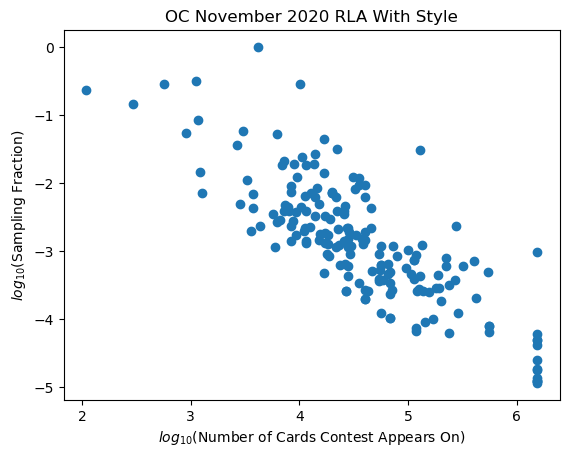

In [24]:
# Plot
plt.scatter(np.log10(contest_cards), np.log10(sampling_fractions))
plt.xlabel("$log_{10}($Number of Cards Contest Appears On$)$")
plt.ylabel("$log_{10}($Sampling Fraction$)$")
plt.title("OC November 2020 RLA With Style")

## Draw the first sample

In [ ]:
%%time
# draw the initial sample using consistent sampling
prng = SHA256(audit.seed)
CVR.assign_sample_nums(cvr_list, prng)
#sampled_cvr_indices needs to be an array for Hart.sample_from_cvrs?
#why are we subtracting 1 from it, i.e. `enumerate(sample-1)` in Hart.sample_from_cvrs
sampled_cvr_indices = CVR.consistent_sampling(cvr_list=cvr_list, contests=contests)
n_sampled_phantoms = np.sum(sampled_cvr_indices > manifest_cards)
print(f'The sample includes {n_sampled_phantoms} phantom cards.')

In [ ]:
len(cvr_list), manifest_cards, audit.max_cards, len(sampled_cvr_indices)

In [4]:
cvr_dict = [{'id': "1_1", 'votes': {'AvB': {'Alice':True}}},
                    {'id': "1_2", 'votes': {'AvB': {'Bob':True}}},
                    {'id': "1_3", 'votes': {'AvB': {'Alice':True}}}]
manifest = pd.DataFrame.from_dict({'Container': ['Mail', 'Mail'], 'Tabulator': [1, 1],\
    'Batch Name': [1, 2], 'Number of Ballots': [1, 2]}, orient = "columns")
manifest, manifest_cards, phantoms = Hart.prep_manifest(manifest, 3, 3)
sample_indices = [0,1]
sampled_card_identifiers, sample_order, mvr_phantoms_sample = Hart.sample_from_manifest(manifest, sample_indices)

In [6]:
manifest

,Container,Tabulator,Batch Name,Number of Ballots,cum_cards
0,Mail,1,1,1,1
1,Mail,1,2,2,3


In [5]:
sampled_card_identifiers

[['Mail', '1', '2', -3, '1-2--3'], ['Mail', '1', '1', 1, '1-1-1']]

In [100]:
# for comparison audit
cards_to_retrieve, sample_order, cvr_sample, mvr_phantoms_sample = \
    Hart.sample_from_cvrs(cvr_list, manifest, sampled_cvr_indices)

# for polling audit
# cards_to_retrieve, sample_order, mvr_phantoms_sample = Dominion.sample_from_manifest(manifest, sample)

In [ ]:
# write the sample
#Dominion.write_cards_sampled(audit.sample_file, cards_to_retrieve, print_phantoms=False)

## Read the audited sample data

In [101]:
# for real data
# with open(audit.mvr_file) as f:
#     mvr_json = json.load(f)

# mvr_sample = CVR.from_dict(mvr_json['ballots'])

# for simulated data, no errors
mvr_sample = cvr_sample

## Find measured risks for all assertions

In [102]:
mvr_sample.sort(key = lambda x: sample_order[x.id]["selection_order"])

In [103]:
CVR.prep_comparison_sample(mvr_sample, cvr_sample, sample_order)  # for comparison audit
# CVR.prep_polling_sample(mvr_sample, sample_order)  # for polling audit

In [104]:
%%time
p_max = Assertion.set_p_values(contests=contests, mvr_sample=mvr_sample, cvr_sample=cvr_sample)
print(f'maximum assertion p-value {p_max}')
done = audit.summarize_status(contests)

maximum assertion p-value 0.025112199214440918

p-values for assertions in contest Proposition 19
	No v Yes: 3.8950800496326726e-252

contest Proposition 19 AUDIT COMPLETE at risk limit 0.05. Attained risk 3.8950800496326726e-252

p-values for assertions in contest Proposition 20
	No v Yes: 0.0

contest Proposition 20 AUDIT COMPLETE at risk limit 0.05. Attained risk 0.0

p-values for assertions in contest Proposition 21
	No v Yes: 1.119168913748306e-248

contest Proposition 21 AUDIT COMPLETE at risk limit 0.05. Attained risk 1.119168913748306e-248

p-values for assertions in contest Proposition 22
	Yes v No: 1.0970012059104293e-138

contest Proposition 22 AUDIT COMPLETE at risk limit 0.05. Attained risk 1.0970012059104293e-138

p-values for assertions in contest Proposition 23
	No v Yes: 3.029765618320665e-146

contest Proposition 23 AUDIT COMPLETE at risk limit 0.05. Attained risk 3.029765618320665e-146

p-values for assertions in contest Proposition 24
	Yes v No: 4.038201884126431e-2

In [38]:
# Log the status of the audit 
audit.write_audit_parameters(contests)

# How many more cards should be audited?

Estimate how many more cards will need to be audited to confirm any remaining contests. The enlarged sample size is based on:

* cards already sampled
* the assumption that we will continue to see errors at the same rate observed in the sample

In [60]:
%%time
sample_size = audit.find_sample_size(contests, cvr_list, mvr_sample)
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=23990
[('Proposition 19', 0), ('Proposition 20', 0), ('Proposition 21', 0), ('Proposition 22', 0), ('Proposition 23', 0), ('Proposition 24', 0), ('Proposition 25', 0), ('AA-City of Orange', 0), ('Proposition 14', 0), ('Proposition 15', 0), ('Proposition 16', 0), ('Proposition 17', 0), ('Proposition 18', 0), ('Z-City of Newport Beach', 0), ('CC-City of Tustin', 0), ('S-City of Fullerton', 0), ('U-City of Fullerton', 0), ('DD-City of Westminster', 0), ('Y-City of Los Alamitos', 0), ('Q-City of Costa Mesa', 0), ('P-City of Cypress', 0), ('BB-City of San Clemente', 0), ('W-City of La Habra', 0), ('X-City of La Habra', 0), ('V-City of Laguna Woods', 0), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 4', 0), ('MUNICIPAL WATER DISTRICT OF ORANGE COUNTY\nDirector, Division 3', 0), ('ORANGE COUNTY WATER DISTRICT\nDirector, Division 6', 0), ('CITY OF GARDEN GROVE\nMayor', 0), ('IRVINE RANCH WATER DISTRICT\nDirector, Division 4', 0), ('CITY OF WESTMINSTER\nMember, City Council, Di

In [61]:
# augment the sample
# reset the seed
seed = 123456
prng = SHA256(seed)
old_sample = cvr_sample
sample = sample_by_index(max_cards, new_size, prng=prng)
incremental_sample = np.sort(list(set(sample) - set(old_sample)))
n_phantom_sample = np.sum([cvr_list[i].phantom for i in incremental_sample])
print("The incremental sample includes {} phantom cards.".format(n_phantom_sample))

NameError: name 'sample' is not defined

In [ ]:
cvr_sample_lookup_new, cvr_sample_new, mvr_phantoms_sample_new = \
                sample_from_cvrs(cvr_list, manifest, incremental_sample)
write_cards_sampled(sample_file, cvr_sample_lookup_new, print_phantoms=False)